In [43]:
# 3rd party libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import SimpleITK as sitk
from tqdm import tqdm

In [44]:
def do_lines_intersect(p1, q1, p2, q2):
    """
    Check if two line segments (p1, q1) and (p2, q2) intersect.
    
    Parameters:
    - p1, q1: Endpoints of the first line segment.
    - p2, q2: Endpoints of the second line segment.
    
    Returns:
    - intersect: True if the line segments intersect, False otherwise.
    """
    def orientation(p, q, r):
        """
        Calculate the orientation of the ordered triplet (p, q, r).
        """
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        if val == 0:
            return 0
        return 1 if val > 0 else 2

    def on_segment(p, q, r):
        # Check y and x coordinates to see if q is between p and r, if so, return True
        if min(p[0], r[0]) <= q[0] <= max(p[0], r[0]) and min(p[1], r[1]) <= q[1] <= max(p[1], r[1]):
            return True
        return False

    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    # Also if points are collinear, check if they are on the segment, if so return True. 
    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True

    return False


def triangles_overlap(tri1, tri2):
    """
    Check if two triangles overlap by checking if any of their edges intersect,
    excluding shared edges or vertices.
    
    Parameters:
    - tri1: The vertices of the first triangle.
    - tri2: The vertices of the second triangle.
    
    Returns:
    - overlap: True if the triangles overlap, False otherwise.
    """
    edges1 = [(tri1[i], tri1[(i + 1) % 3]) for i in range(3)]
    edges2 = [(tri2[i], tri2[(i + 1) % 3]) for i in range(3)]
    
    for edge1 in edges1:
        for edge2 in edges2:
            if do_lines_intersect(edge1[0], edge1[1], edge2[0], edge2[1]):
                # Check if the edges are not shared
                if not (np.array_equal(edge1[0], edge2[0]) or np.array_equal(edge1[0], edge2[1]) or
                        np.array_equal(edge1[1], edge2[0]) or np.array_equal(edge1[1], edge2[1])):
                    return True
    return False


def check_overlapping_triangles(points, triangulation, npy_path="output/"):
    """
    Check if a Delaunay triangulation has overlapping triangles.
    
    Parameters:
    - points: The set of points used for the triangulation.
    - triangulation: The Delaunay triangulation object.
    
    Returns:
    - overlap: True if there are overlapping triangles, False otherwise.
    """
    num_overlapping_triangles = 0
    num_checks = 0
    overlap = False
    overlapping_triangles = []  # Store overlapping triangles for debugging
    
    triangle_stats = {}
    
    # Check for overlapping triangles
    for i, simplex1 in enumerate(triangulation.simplices):
        tri1 = points[simplex1]
        
        overlapped = []
        
        # Simplex to check against
        for j, simplex2 in enumerate(triangulation.simplices):
            if i >= j:  # Avoid checking the same pair twice
                continue
            tri2 = points[simplex2]
            num_checks += 1
            
            # If triangles overlap, increment the count
            if triangles_overlap(tri1, tri2):
                # Print the first time
                #if num_overlapping_triangles == 0:
                #    tri1_str = ", ".join(map(str, tri1))
                #    tri2_str = ", ".join(map(str, tri2))
                #    print(f"\tTriangles overlap on triangle {tri1_str} and triangle {tri2_str}.")
                #    print("\t...")
                    
                # Add to list of overlapping triangles
                overlapping_triangles.append((tri1, tri2))
                overlap = True
                num_overlapping_triangles += 1
                
                # Add index to stats for current simplex index
                overlapped.append(j)
                #return True
                
        # Add to stats for current simplex index
        triangle_stats[i] = overlapped
    # Print the results
    #print("\tNumber of overlapping triangle checks failed:", num_overlapping_triangles, "/", num_checks)
    # Save the overlapping triangles
    #if npy_path is not None:
    #    np.save(npy_path + "overlapping_triangles.npy", overlapping_triangles)
    #    np.save(npy_path + "triangle_stats.npy", triangle_stats)
    return overlap


def validate_triangulation(points, tri):
    """
    Validate a triangulation.
    
    Parameters:
    - points: The set of points used for the triangulation.
    
    Returns:
    - valid: True if the triangulation is valid, False otherwise.
    """
    # Check for overlapping triangles
    #print("Checking for no overlapping triangles...")
    if check_overlapping_triangles(points, tri):
        #print("\tOverlapping triangles check FAILED.")
        return False
    #print("\tOverlapping triangles check PASSED.")
    return True

In [45]:
curr_moving_path = "output/curr_moving.npy"
curr_fixed_path = "output/curr_fixed.npy"

curr_moving = np.load(curr_moving_path)
curr_fixed = np.load(curr_fixed_path)

In [54]:
valid_mpts = curr_moving[:3].tolist()
valid_fpts = curr_fixed[:3].tolist()
num_invalid = 0

for i in tqdm(range(3, len(curr_moving))):
    curr_mpts = valid_mpts.copy()
    curr_fpts = valid_fpts.copy()
    curr_mpts.append(curr_moving[i].tolist())
    curr_fpts.append(curr_fixed[i].tolist())
    curr_tri = Delaunay(np.array(curr_mpts))
    is_valid = validate_triangulation(np.array(curr_fpts), curr_tri)
    if is_valid:
        valid_mpts = curr_mpts
        valid_fpts = curr_fpts
    else:
        num_invalid += 1
        
        
valid_mpts = np.array(valid_mpts)
valid_fpts = np.array(valid_fpts)
valid_tri = Delaunay(valid_mpts)
print("Number of invalid triangulations:", num_invalid, "out of", len(curr_moving) - 3)

100%|██████████| 1323/1323 [00:03<00:00, 365.12it/s]

Number of invalid triangulations: 2638 out of 1323


In [55]:
curr_mpts

[[17, 178],
 [17, 179],
 [18, 172],
 [18, 167],
 [18, 168],
 [18, 169],
 [18, 170],
 [271, 357]]

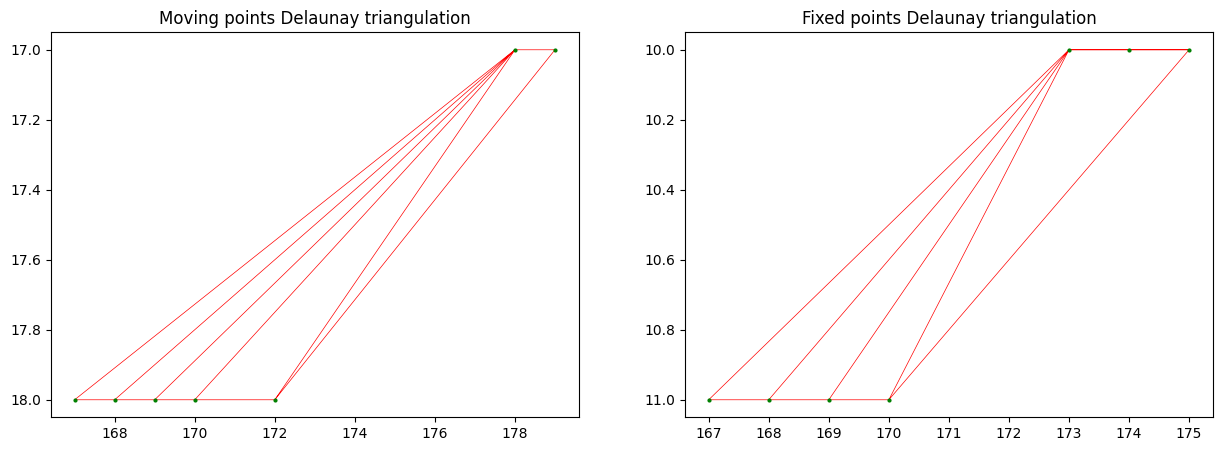

In [56]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(valid_mpts[:, 1], valid_mpts[:, 0], 'go', markersize=2)
plt.triplot(valid_mpts[:, 1], valid_mpts[:, 0], valid_tri.simplices, color='red', linewidth=0.5)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.title('Moving points Delaunay triangulation')

plt.subplot(1, 2, 2)
plt.plot(valid_fpts[:, 1], valid_fpts[:, 0], 'go', markersize=2)
plt.triplot(valid_fpts[:, 1], valid_fpts[:, 0], valid_tri.simplices, color='red', linewidth=0.5)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.title('Fixed points Delaunay triangulation')
plt.show()